In [ ]:
# encoding=utf8

# 线性回归分析Linear Regression Analysis

Linear Regression: 
+ Implementation
+ Hyperparameters
+ their Optimizations

### Libraries Import

In [2]:
!pip install tabulate

In [3]:
import time
import tabulate

import matplotlib
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,15)

### Load Data

Data came from `sklearn` datasets. For the sake of visualization we will use 2 features from this data set. What they mean is irrelevant to us. 

In [4]:
full_data = datasets.load_diabetes()
one_feature = full_data.data[:, np.newaxis, 2]

x_training = one_feature[:-100]
y_training = full_data.target[:-100]

x_testing = one_feature[-100:]
y_testing = full_data.target[-100:]

### Plot
Plot the initial data `<x, y>`.

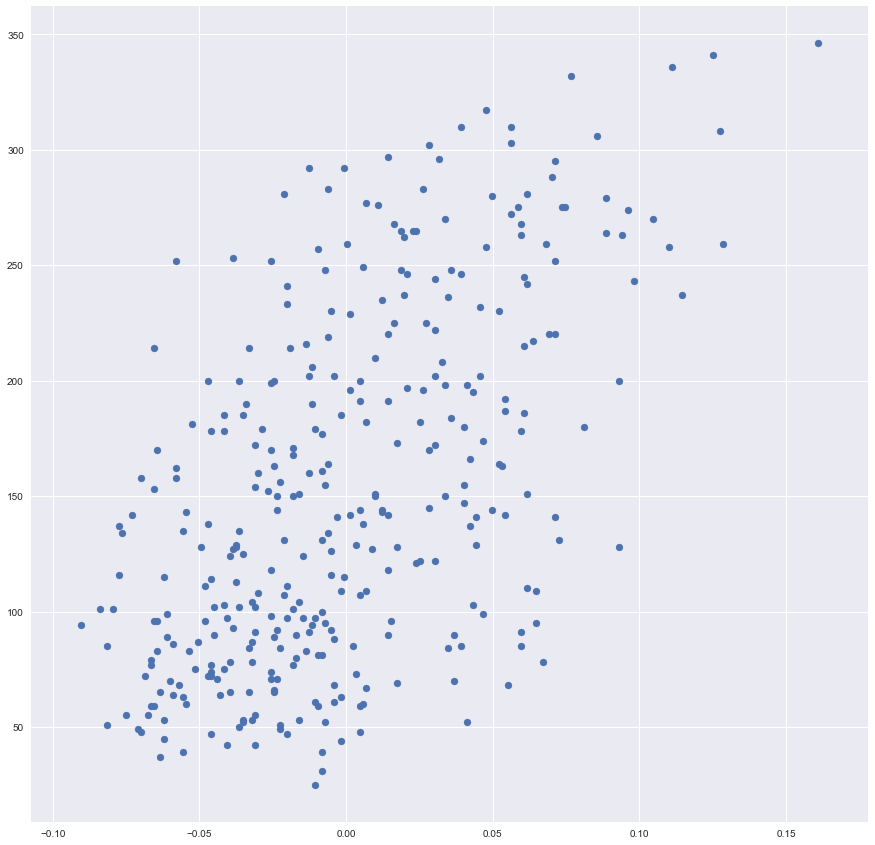

In [5]:
plt.scatter(x_training, y_training)

# Linear Regression: Ordinary Least Squares

In [6]:
def ordinary_least_squares(x, y):
    '''
    Find weights for hypothesis of the form:
        w*x + b
    using ordinary leasts squares method where
    w defined as b0, b as b1 by convention.
    
    Params:
        x: training data values
        y: training data lables
    
    Returns:
        hypothesis function
    '''    
    xmean = np.mean(x)
    ymean = np.mean(y)

    m = len(x)
    
    numerator = 0
    denominator = 0

    for i in range(m):
        numerator += (x[i] - xmean) * (y[i] - ymean)
        denominator += (x[i] - xmean)**2
    
    b1 = numerator / denominator
    b0 = ymean - (b1 * xmean)
    
    # b1 and b0 are np arrays -> extract their actual values
    b = b0[0]
    w = b1[0]
    
    return lambda x: w*x + b

### Create a Hypothesis

`ordinary_least_squares` returns a lambda function which represents a hypothesis, so we can use it like a `f(x)` math function.

In [7]:
hypothesis = ordinary_least_squares(x_training, y_training)

### Make a Prediction

In [8]:
prediction = hypothesis(x_training)
prediction = prediction.reshape((342,))

### Plot Data and Linear Regression

It is easy to verify approximate correctness of an algorithm if line is right in the middle of the data.

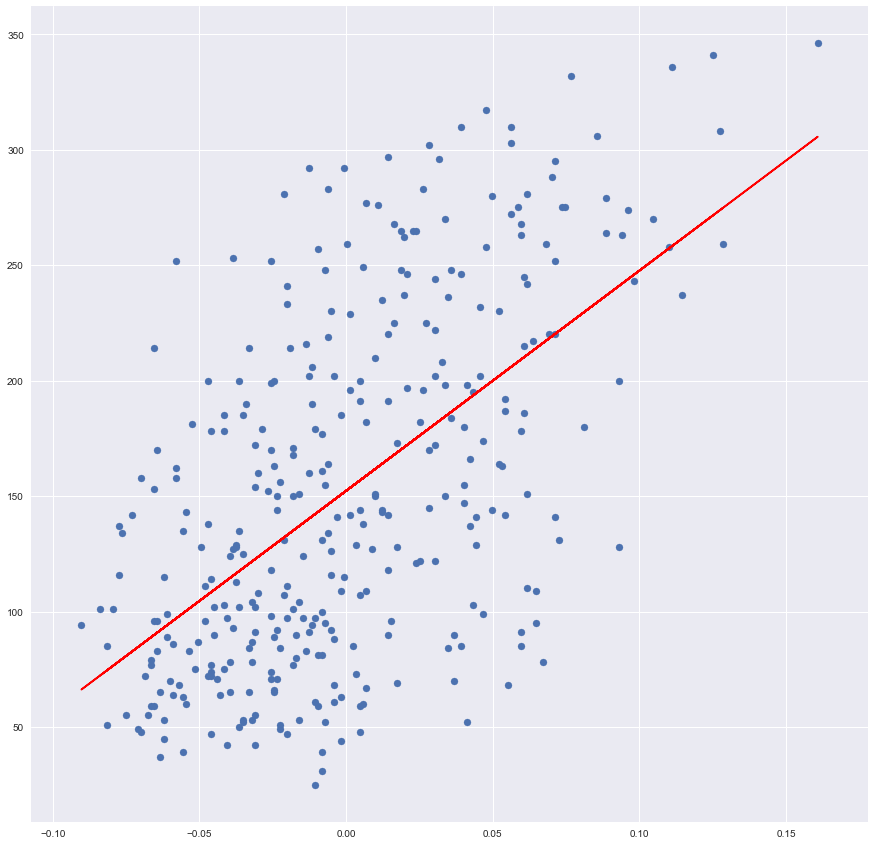

In [9]:
plt.scatter(x_training, y_training)
plt.plot(x_training, prediction, color='red')

### Verify

Lets take `LinearRegression` from `sklearn` as an ethalon implementation and compare results with our custom solution. 

In [10]:
model = linear_model.LinearRegression()
model.fit(x_training, y_training)
sk_prediction = model.predict(x_training)

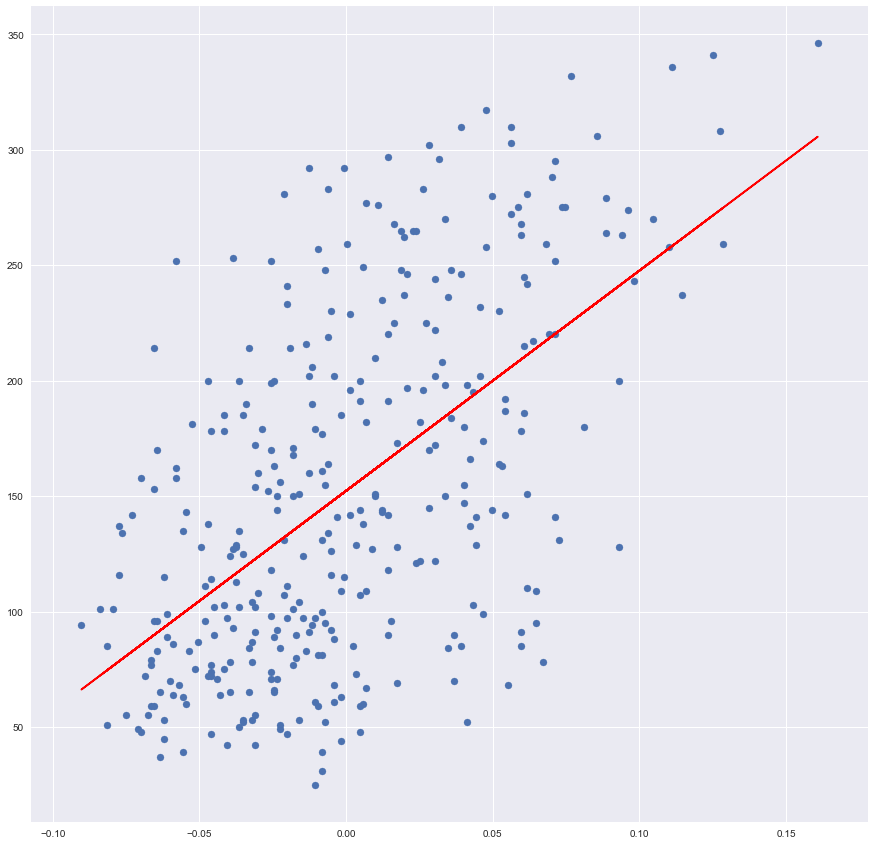

In [11]:
plt.scatter(x_training, y_training)
plt.plot(x_training, sk_prediction, color='red')

### Implement an Evaluator

Mean squared error implementation.

In [12]:
def mean_squared_error_custom(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth)**2)) / (2*m)
    return mse

### Compare

Compare custom linear regression implementation and one from `sklearn`. So far plots are looking the same, but what about numbers?

In [13]:
print(mean_squared_error_custom(y_training, sk_prediction))
print(mean_squared_error_custom(y_training, prediction))

1965.39377764
1965.39377764


The result is the same, therefore implementation is correct.


---


# Batch Gradient Descent


Lets prepare the data and buid:

* `X` is a feature array with built-in bias
* `w` initialization for weights
* `y` ground truth

In [14]:
x1 = full_data.data[:, np.newaxis, 1]
x1 = np.squeeze(np.asarray(x1[:-100]))

x2 = full_data.data[:, np.newaxis, 2]
x2 = np.squeeze(np.asarray(x2[:-100]))

ones = np.ones(len(x1))

X = np.array([ones, x1, x2]).T
y = full_data.target[:-100]

### Implementation

In [15]:
def batch_gradient_descent(X, y, lrate, niter):
    weights = np.zeros(X.shape[1])
    
    history = []
    m = len(y)
    
    predict      = lambda x: np.dot(x, weights)
    derivative_w = lambda loss: (X.T.dot(loss)) / m
    
    for i in range(niter):
        hypothesis = predict(X)
        loss = hypothesis - y
        weights = weights - lrate * derivative_w(loss)
        
        if i % 50 == 0:
            history.append(mean_squared_error_custom(X.dot(weights), y))

    return predict, history

### Optimize Weights

In [16]:
predictor, history = batch_gradient_descent(X, y, 0.05, 50000)

### Plot Training History

History was written by `batch_gradient_descent` each 50 iterations. Each history entry is a value for a `cost_function`.

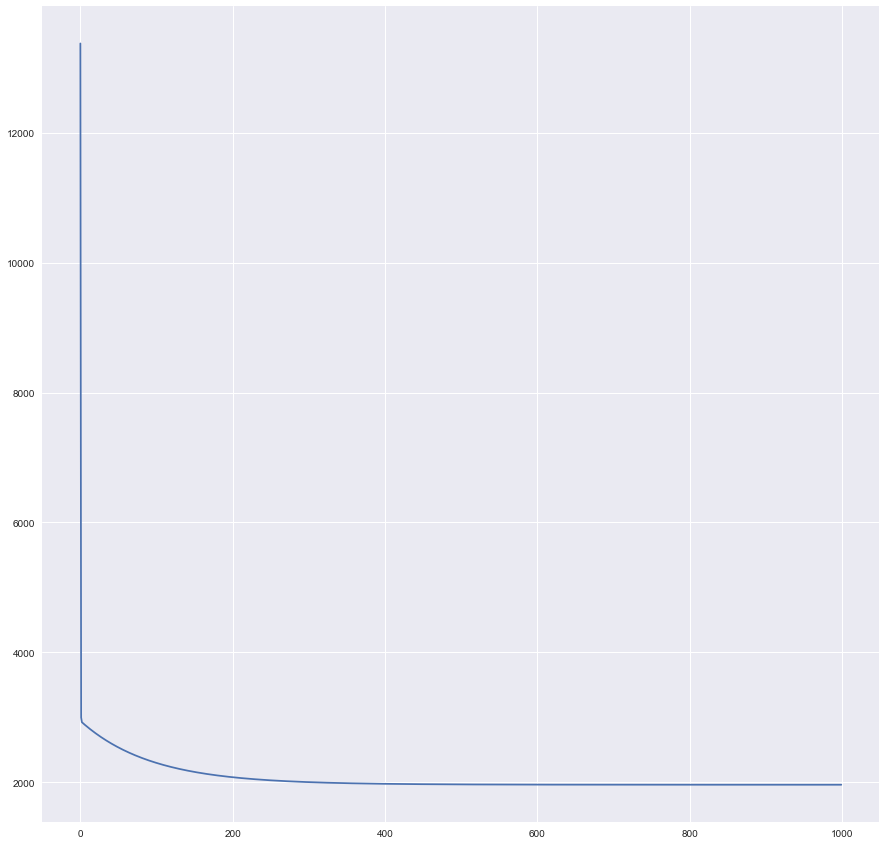

In [17]:
plt.plot(history)

### Make a Prediction and Get a Mean Squared Error

In [18]:
gds_predictions = predictor(X)
err = mean_squared_error_custom(gds_predictions, y)

print(err)

1963.4934687


### Validate

Validate the result of the custom BGD with running the same routine using `sklearn`.

In [19]:
sk_reg = linear_model.LinearRegression()
sk_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
sk_reg_pred = sk_reg.predict(X)

In [21]:
mean_squared_error_custom(sk_prediction, y)

1965.3937776396358

We can se that mean square error is kind of similar. This is happened because BGD has hyperparameters which can be tuned and edited, while OLS has no hyperparameters, therefore output is always the same.


---

# Hyperparameters

Lets observe *how* hyperparameters affects our algorithm.

In `lrates` we define various values for learning rate hyperparameter, and in `niterations` various values for number of iterations hyperparamenters.

Methodology looks as the following: we will run Batch Gradient Descent with each possible combination of hyperparameters and compare them in multiple ways.

In [22]:
lrates = [.5, .1, .01, .001, .0001]
niterations = [25000, 50000, 150000]

`test` function iterates over each hyperparameter and put all the results in record list.

In [23]:
def test(X, y):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weigths, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weigths, history=records, time=delta))
    
    return record

In [24]:
rec = test(X, y)

### Plot

Lets plot all the GBD histories

In [25]:
def plot_records(records):
    for record in records:
        label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], record["time"])
        plt.plot(record['history'], label=label)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

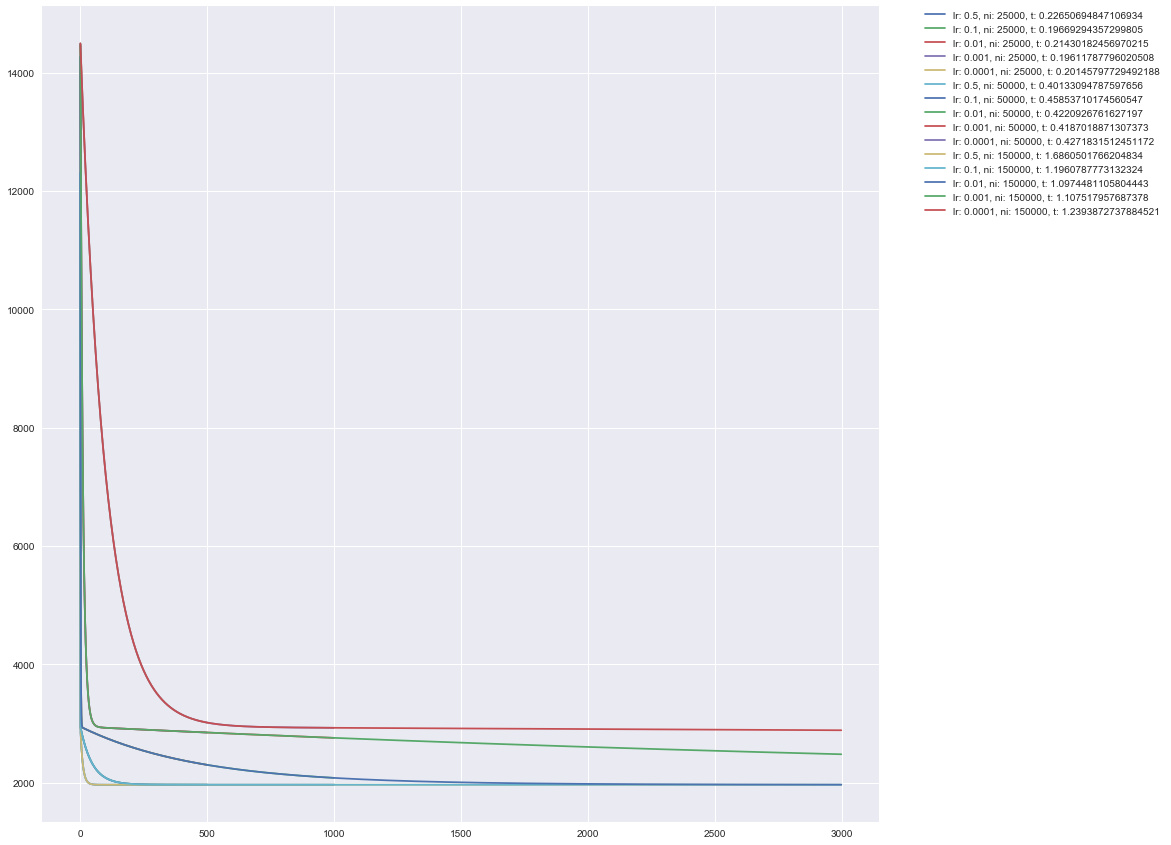

In [26]:
plot_records(rec)

Actually this plot is not any good for now because we can not read the data from it. However we can observe that there is a difference indeed.

### Plot: Take 2

First plot didn't work out well, lets plot each BGD individually.

In [27]:
def plot_records(records):
    name_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O'}
    figure, plots = plt.subplots(5, 3)
    figure.tight_layout()
    plots = plots.flatten()
    for i, record in enumerate(records):
        time = "{0:.4f}".format(record['time'])
        label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], time)
        plots[i].plot(record['history'], label=label) 
        plots[i].legend(loc='upper right')
        plots[i].set_title(name_map[i])

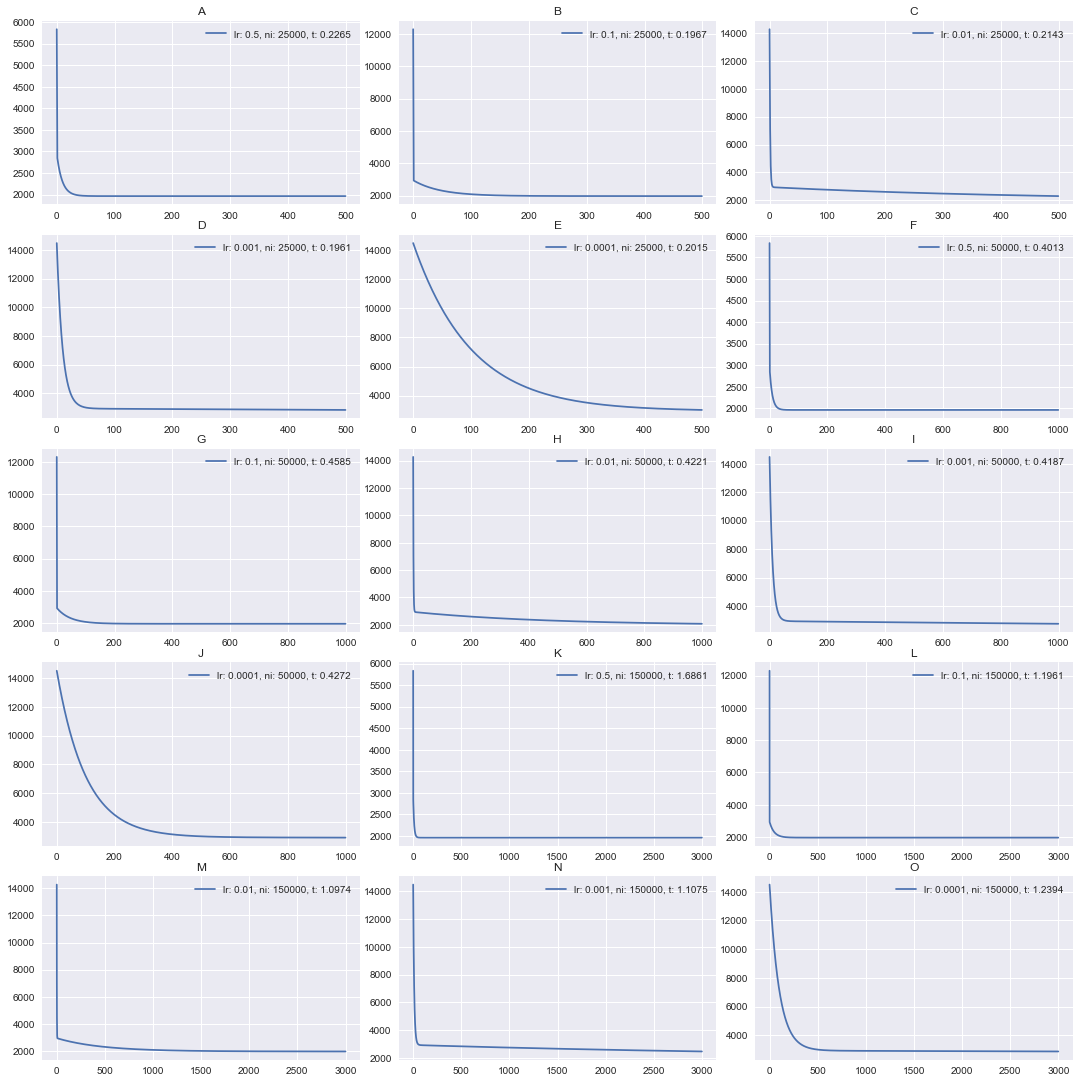

In [28]:
plot_records(rec)

### More Data

Plot from above is good and clear, lets print the data out as a table.

First prepare the data, sort it by time and print.

In [29]:
time_sorted_records = sorted(rec, key=lambda k: k['time']) 

In [30]:
tab_data = time_sorted_records.copy()

In [31]:
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']

In [32]:
print(tabulate.tabulate(tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

  lrate    niter    elapsed time     cost
-------  -------  --------------  -------
 0.001     25000        0.196118  2846.12
 0.1       25000        0.196693  1963.49
 0.0001    25000        0.201458  3014.51
 0.01      25000        0.214302  2299.74
 0.5       25000        0.226507  1963.47
 0.5       50000        0.401331  1963.47
 0.001     50000        0.418702  2755.94
 0.01      50000        0.422093  2079.21
 0.0001    50000        0.427183  2926.01
 0.1       50000        0.458537  1963.47
 0.01     150000        1.09745   1965.21
 0.001    150000        1.10752   2478.86
 0.1      150000        1.19608   1963.47
 0.0001   150000        1.23939   2884.86
 0.5      150000        1.68605   1963.47


Data is sorted by time because I choosed this parameter as most important. Generally we want to compute as fast as possible while result is sufficiently good.

We can see that generally that cost `3926.93` can be considered as **converged**.

In our case, *with a given data*, learning rate of `.5` converged after `25000` iterations, while learning rate of `.0001` has a long way to go until convergence.

Lets actually see how many iterations it need to converge:

In [33]:
weights_t, records_t = batch_gradient_descent(X, y, 0.0001, 2000000)
print(records_t[-1])

2379.23502472


Even after `2,000,000` iterations GBD with learning rate of `.0001` converged to cost of `4758.47`, which is comparable result to `<.01, 25,000>` hyperparameter pair.

### Optimal Hyperparameters

In [34]:
lrates = [2, 1.2, 1, .8, .5]
niterations = [1000, 5000, 10000]

optimal_rec = test(X, y)

time_sorted_optimal_records = sorted(optimal_rec, key=lambda k: k['time'])
optimal_tab_data = time_sorted_optimal_records.copy()

for r in optimal_tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']

print(tabulate.tabulate(optimal_tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

  lrate    niter    elapsed time      cost
-------  -------  --------------  --------
    1       1000       0.0157318   1980.58
    0.8     1000       0.0174887   2001.64
    1.2     1000       0.0175478   1971.17
    0.5     1000       0.0182509   2091.52
    2       1000       0.0186079  13555.3
    0.8     5000       0.064554    1963.47
    0.5     5000       0.0676041   1963.5
    1.2    10000       0.077662    1963.47
    1      10000       0.0778532   1963.47
    1       5000       0.083149    1963.47
    1.2     5000       0.0850191   1963.47
    2       5000       0.100332   13715.3
    0.8    10000       0.114372    1963.47
    2      10000       0.125805   13918.9
    0.5    10000       0.171453    1963.47


### Can We Do Better?

In [35]:
lrates = [3, 2.5, 2, 1.5, .8]
niterations = [1000, 5000, 10000]

optimal_rec = test(X, y)

time_sorted_optimal_records = sorted(optimal_rec, key=lambda k: k['time'])
optimal_tab_data = time_sorted_optimal_records.copy()

for r in optimal_tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']

print(tabulate.tabulate(optimal_tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract


  lrate    niter    elapsed time      cost
-------  -------  --------------  --------
    0.8     1000       0.0130718   2001.64
    1.5     1000       0.0261681   1965.8
    2       1000       0.0266931  13555.3
    2.5     1000       0.0296712    inf
    3       1000       0.0334742    inf
    2       5000       0.0542381  13715.3
    1.5     5000       0.060653    1963.47
    2.5     5000       0.069901     nan
    0.8    10000       0.0707219   1963.47
    1.5    10000       0.0721672   1963.47
    2.5    10000       0.077673     nan
    0.8     5000       0.083287    1963.47
    3       5000       0.0835819    nan
    2      10000       0.0984182  13918.9
    3      10000       0.169493     nan


In [36]:
lrates = [3, 2.5, 2, 1.5, .8]
niterations = [1000, 5000, 10000]

optimal_rec = test(X, y)

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract


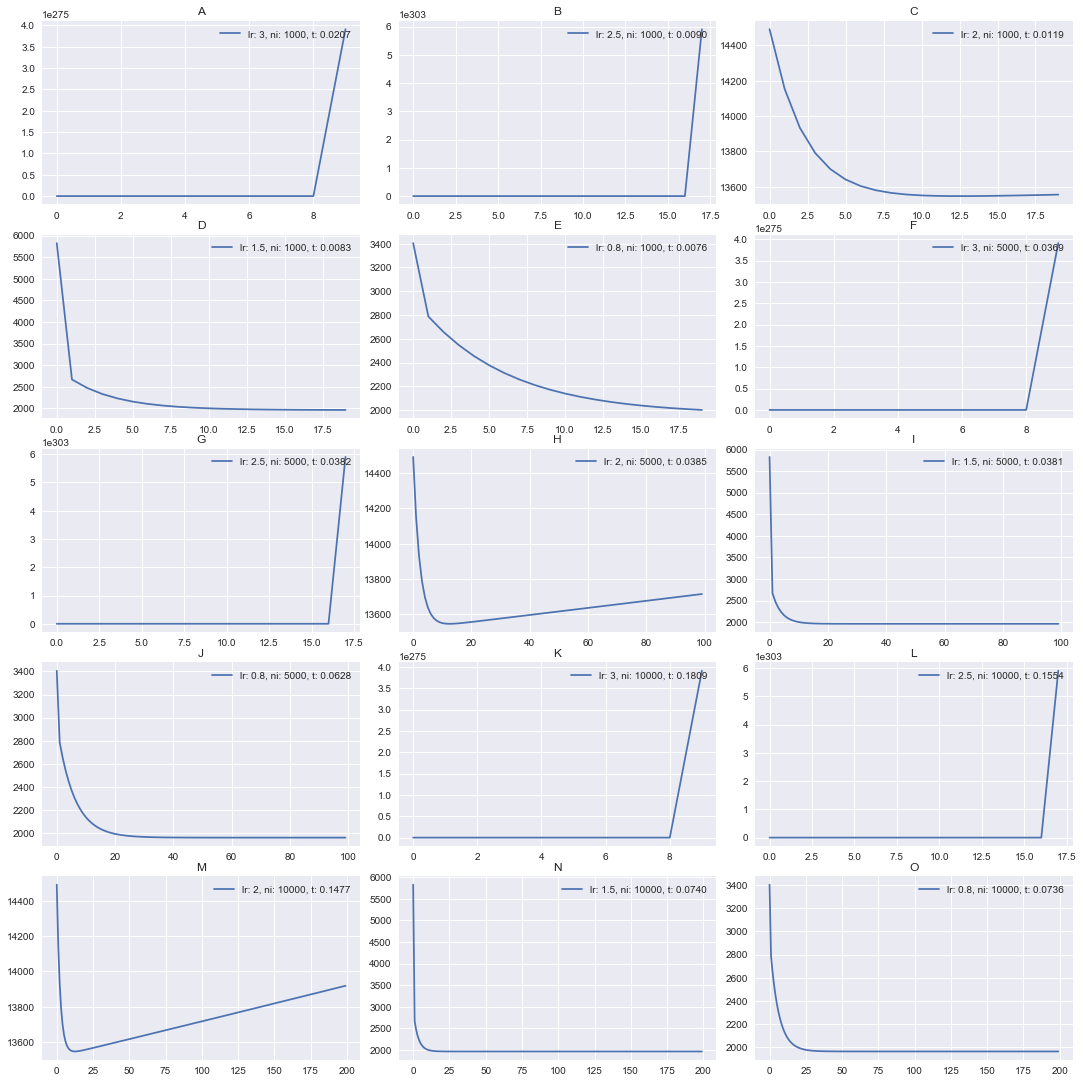

In [37]:
plot_records(optimal_rec)